In [3]:
#Importing Required Libraries
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

torch.Size([3, 32, 32])


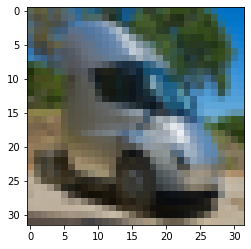

In [4]:
#Loading images and pre-processing it
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

flat_img = 3072 #32 * 32 * 2 -- flattened image size with 3 color channels.

img = Image.open('truck.jpeg')
real_img = transform(img)

torch.manual_seed(69)
fake_img = torch.rand(1, 100)

plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

In [5]:
#Creating  Discriminator Model

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(flat_img, 10000),
        nn.ReLU(),
        nn.Linear(10000, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img = img.view(1, -1)
    out = self.linear(img)

    return out

In [6]:
#Creating Generator Model

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(100, 10000),
        nn.LeakyReLU(),
        nn.Linear(10000, 4000),
        nn.LeakyReLU(),
        nn.Linear(4000, flat_img)
    )

  def forward(self, latent_space):
    latent_space = latent_space.view(1, -1)
    out = self.linear(latent_space)

    return out

In [7]:
#Initializing the Models. Note: The code includes the option to run on either GPU or CPU.

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discr = Discriminator().to(device)
gen = Generator().to(device)

opt_d = optim.SGD(discr.parameters(), lr=0.001, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

In [8]:
#Training Loop
epochs = 500
discr_e = 4
gen_e = 3

for ep in tqdm(range(epochs), total = epochs):

    #Training the Discriminator Model
    for i in range(discr_e):
        opt_d.zero_grad()

        out_d1 = discr(real_img.to(device))

        #Calculating Loss for Real Image
        loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))
        loss_d1.backward()

        out_d2 = gen(fake_img.to(device)).detach()

        #Calculating Loss for Fake Image
        loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
        loss_d2.backward()

        opt_d.step()

    #Training the Generator Model
    for i in range(gen_e):
        opt_g.zero_grad()

        out_g = gen(fake_img.to(device))

        #Binary Cross Entropy Loss
        loss_g = torch.log(1.0 - (discr(out_g.to(device))))
        loss_g.backward()

        opt_g.step()


  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


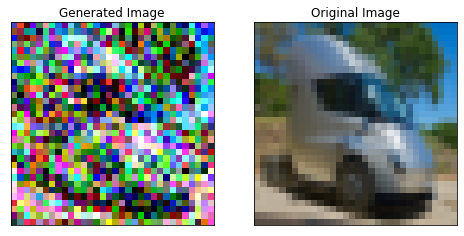

In [10]:
#Comparing the results
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.resize(3, 32, 32).cpu().detach().numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
plt.show()